In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
import pandas as pd
from scipy import stats,interpolate
import urllib
import plotly.express as px
import plotly.graph_objects as go


In [2]:
import urllib.request

with urllib.request.urlopen('ftp://ftp.cpc.ncep.noaa.gov/wd52dg/data/indices/nao_index.tim') as url:
    mybytes = url.read()
    mystr = mybytes.decode('utf8')
    url.close
    mystr_s = mystr.split('\n')


In [3]:
all_vals = []

for i in np.arange(9, len(mystr_s)-1):
    line = mystr_s[i].strip().split()
    for i in line:
        all_vals.append(i)

In [4]:
dates = []
index = []

for i in range(0, len(all_vals)-3, 3):
    if int(all_vals[i+1]) < 10:
        k = '0'+all_vals[i+1]
    else:
        k = all_vals[i+1]
    
    dates.append(datetime.strptime( all_vals[i]+k, '%Y%m'))
    index.append(float(all_vals[i+2]))
    

In [5]:
nao = xr.DataArray(index, coords = {'time': dates}, dims = 'time')


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



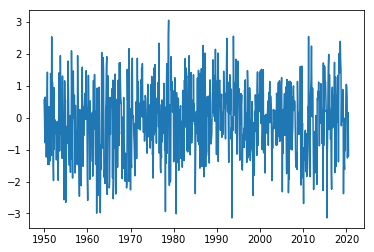

In [6]:
plt.plot(nao.time, nao.values)

In [7]:
seasonal = []

for i in np.arange(11, len(nao)-3, 3):
    #print(nao[i:i+3]['time.season'].values)
    
    seasonal.append(np.mean(nao[i:i+3]))

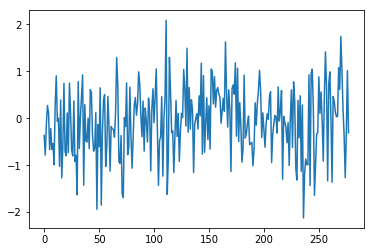

In [8]:
plt.plot(seasonal)

In [9]:
year = []

for i in np.arange(12, len(nao)-12, 12):
    #print(nao[i:i+11]['time.year'].values)
    
    year.append(np.mean(nao[i:i+11]))

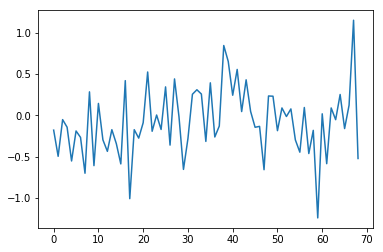

In [10]:
plt.plot(year)

In [11]:
dec = []

for i in np.arange(12, len(nao)-108, 108):
    #print(nao[i:i+107]['time.year'].values)
    
    dec.append(np.mean(nao[i:i+107]))

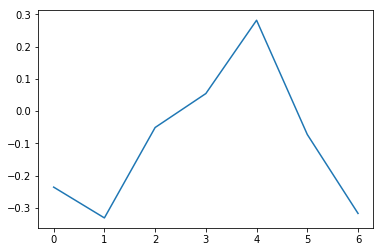

In [12]:
plt.plot(dec)

In [13]:
def line_smooth_5020(needs_smoothed, len_in, len_out):
    
    x_new = np.linspace(0, len_in, len_out)
    a_BSpline = interpolate.make_interp_spline(np.arange(0,len_in), needs_smoothed)
    y_new = a_BSpline(x_new)
    
    return x_new, y_new

In [42]:
nao_x, nao_y = line_smooth_5020(nao, len(nao), len(nao)*5)

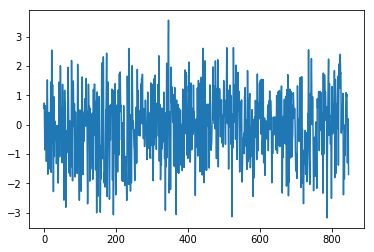

In [15]:
plt.plot(nao_x[:-8], nao_y[:-8])

In [43]:
nao_szn_x, nao_szn_y = line_smooth_5020(seasonal, len(seasonal), len(nao)*5)

In [44]:
nao_years_x, nao_years_y = line_smooth_5020(year, len(year), len(nao)*5)

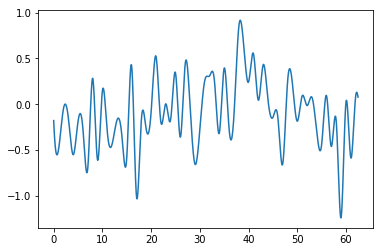

In [20]:
plt.plot(nao_years_x[:-800], nao_years_y[:-800])

In [45]:
nao_dec_x, nao_dec_y = line_smooth_5020(dec, len(dec), len(nao)*5)

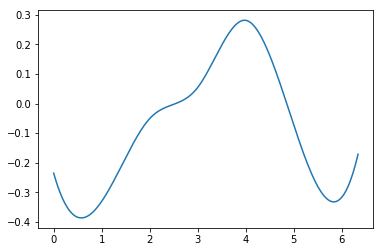

In [23]:
plt.plot(nao_dec_x[:-800], nao_dec_y[:-800])

In [28]:
###### I commented out the last ~ 800 or so or else it goes super high for the interpolation 

In [24]:
nao_years_x = nao_years_x[:-800].astype(np.float16)
nao_y = nao_y[:-800].astype(np.float16)
nao_szn_y = nao_szn_y[:-800].astype(np.float16)
nao_years_y = nao_years_y[:-800].astype(np.float16)
nao_dec_y = nao_dec_y[:-800].astype(np.float16)

In [54]:
np.save('nao_x.npy',nao_years_x[1200:-400].astype(np.float32))
np.save('nao_y.npy',nao_y[1200:-400].astype(np.float32))
np.save('nao_szn_y.npy',nao_szn_y[1200:-400].astype(np.float32))
np.save('nao_years_y.npy',nao_years_y[1200:-400].astype(np.float32))
np.save('nao_dec_y.npy',nao_dec_y[1200:-400].astype(np.float32))

In [47]:
((nao_x[:-200].size * nao_x[:-200].itemsize) /1024) * 5

157.6171875

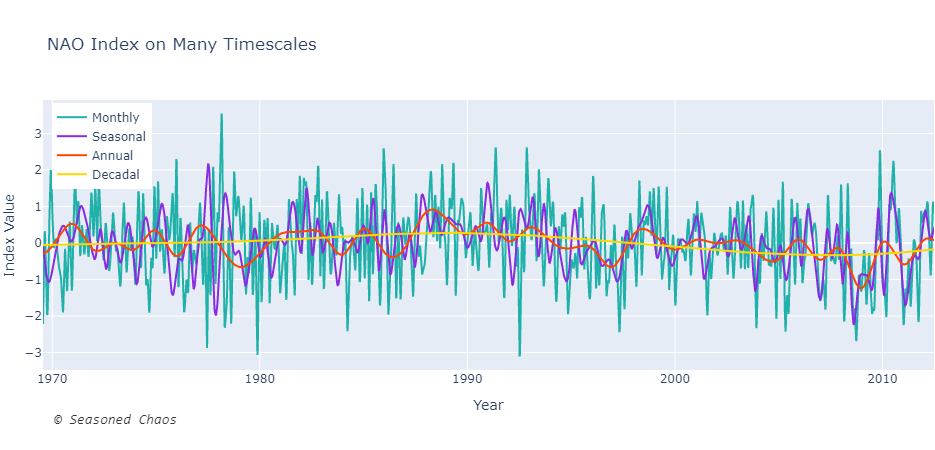

In [106]:
fig = go.Figure()

fig.add_trace(go.Scatter(x =nao_x, y = nao_y,
                    mode='lines',
                    marker=dict(color='lightseagreen'),
                    name='Monthly'))

fig.add_trace(go.Scatter(x=nao_x, y=nao_szn_y,
                    mode='lines',
                    marker=dict(color='blueviolet'),
                    name='Seasonal'))

fig.add_trace(go.Scatter(x=nao_x, y=nao_years_y,
                    mode='lines',
                    marker=dict(color='orangered'),
                    name='Annual'))

fig.add_trace(go.Scatter(x=nao_x, y=nao_dec_y,
                    mode='lines',
                    marker=dict(color='gold'),
                    name='Decadal'))

fig.update_layout(title='NAO Index on Many Timescales',
#                   autosize=False,
#                   height=200,
#                   width=420,
                  margin=dict(
                        r=0.99,
                        l=0.1
                    ),
                   xaxis_title='Year',
                   yaxis_title='Index Value',
                   xaxis = dict(
                   tickmode = 'array',
                   tickvals = [0,10,20,30,40,50,60,70],
                   ticktext = ['1950','1960','1970','1980','1990','2000','2010','2020']),
                   hovermode='x')

fig.update_traces(hoverinfo='y')

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.add_annotation(
            x=.01,
            y=-.22,
            xref="paper",
            yref="paper",
            text="<i>\xa9 Seasoned Chaos</i>",
            showarrow=False, opacity=.8,
            font=dict(
                family="Dill Alternate,monospace",
                size=14,
                color="black"
            ))